In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dask.array as da
from distributed import Client
from fish.image.zds import ZDS
from os import makedirs
from os.path import exists
from functools import partial
from scipy.ndimage.filters import median_filter
from fish.util.distributed import get_jobqueue_cluster
from dask.array import coarsen
from skimage.io import imsave
import time
from scipy.interpolate import interp1d

In [20]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_1_gfaprgeco_OGB_5N_6dpf_singleplane_20181125_173551/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_2_gfaprgeco_OGB_5N_6dpf_singleplane_25hz_20181125_180852/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_3_gfaprgeco_OGB_5N_6dpf_singleplane_25hz_20181125_183338/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_4_gfaprgeco_OGB_5N_6dpf_singleplane_volume_2Hz_20181125_190643/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish1/20181128_1_2_dbhgal4_uascochr_gfaprgeco_4dpf_stimMO_20181128_154713/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish1/20181128_1_4_dbhgal4_uascochr_gfaprgeco_4dpf_stimMO_afterpuffAPVNBQX_20181128_165722/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish1/20181128_1_6_dbhgal5_uascochr_gfaprgeco_4dpf_stimMO_after2ndpuffAPVNBQX_20181128_185903/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish2/20181128_2_4_dbhgal5_uascochr_gfaprgeco_4dpf_beforepuff_20181128_215816/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish2/20181128_2_6_dbhgal5_uascochr_gfaprgeco_4dpf_afterpuff_20181128_223045/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish2/20181128_2_7_dbhgal5_uascochr_gfaprgeco_4dpf_afterpuff_20181128_230431/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish1/20181129_1_2_dbhgal5_uascochr_gfaprgeco_5dpf_stim_beforepuff_20181129_135911/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish1/20181129_1_4_dbhgal5_uascochr_gfaprgeco_5dpf_stimMO_afterpuff_20181129_144050/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish2/20181129_2_4_dbhgal5_uascochr_gfaprgeco_5dpf_MO_befoerpuff_20181129_170747/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish2/20181129_2_6_dbhgal5_uascochr_gfaprgeco_5dpf_MO_afterpuff_20181129_175624/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish2/20181130_2_2_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_205704/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish2/20181130_2_4_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_221617/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish3/20181130_3_2_dbhgal4_uascochr_gfaprgeco_6dpf_MO_stim_20181201_003220/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish3/20181130_3_4_dbhgal4_uascochr_gfaprgeco_6dpf_MO_stim_20181201_005739/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish3/20181130_3_6_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_2ndmorning_20181201_110204/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish1/20181201_1_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_123803/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish1/20181201_1_3_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_140931/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish2/20181201_2_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_163402/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish3/20181201_3_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_194410/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish4/20181201_4_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_210919/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish4/20181201_4_4_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_233307/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish1/20181130_1_2_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_172435/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish1/20181130_1_4_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_191810/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_2_gfapgc_rhod5N_5dpf_CLOL_20181202_175842/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_3_gfapgc_rhod5N_5dpf_CLOL_20181202_191945/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_5_gfapgc_rhod5N_5dpf_CLOL_20181202_205105/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_6_gfapgc_rhod5N_5dpf_CLOL_20181202_212358/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_7_gfapgc_rhod5N_5dpf_CLOL_20181202_215737/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish4/20181204_4_2_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwm_20181204_204822/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish4/20181204_4_3_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwm_continue_20181204_225005/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish5/20181204_5_2_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwim_20181205_000340/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish5/20181204_5_3_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwim_20181205_020340/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181205/fish1/20181205_1_2_gfaprgeco_dbhgal4_uascochr_7dpf_stimMO_pairSwim_20181205_102014/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish8/20181209_8_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181209_211424/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish9/20181209_9_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181209_233813/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish10/20181209_10_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181210_010455/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish8/20181209_8_3_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_volume_20181209_221914/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish1/20181211_1_2_gfaprgeco_dbhcochr_6dpf_stimMO_pairSwim_20181211_130143/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_2_gfaprgeco_dbhcochr_6dpf_stimMO_pairSwim_20181211_144028/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_3_gfaprgeco_dbhcochr_6dpf_stimMO_pairSwim_20181211_151816/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_4_gfaprgeco_dbhcochr_6dpf_stimMO_blockallreceptor_20181211_160257/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_5_gfaprgeco_dbhcochr_6dpf_stimMO_blockallreceptor_20181211_174107/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_6_gfaprgeco_dbhcochr_6dpf_stimMO_blockallreceptor_20181211_182606/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish3/20181211_3_2_gfaprgeco_dbhcochr_6dpf_stimMO_pairswim_20181211_193657/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish3/20181211_3_3_gfaprgeco_dbhcochr_6dpf_stimMO_blockNE_20181211_202814/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181212/fish1/20181212_1_1_gfapgc_claire_5dpf_CLOL_singleplane_20181212_105705/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181212/fish1/20181212_1_2_gfapgc_claire_5dpf_CLOL_volume_20181212_113923/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181212/fish2/20181212_2_2_gfaprgeco_dbhcoch_6dpf_stimMO_blockNEerceptors_20181212_202009/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181212/fish3/20181212_3_2_gfaprgeco_dbhcoch_6dpf_stimMO_blockNEerceptors_20181212_235317/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181212/fish4/20181212_4_2_gfaprgeco_dbhcoch_6dpf_stimMO_blockNEerceptors_20181213_014042/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181213/fish1/20181213_1_2_dbhcochr_gfaprgeco_7dpf_stimMO_blockNE_20181213_192742/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181213/fish2/20181213_2_2_dbhcochr_gfaprgeco_7dpf_stimMOBlockNE_20181213_225334/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish1/20181213_1_2_dbhcochr_gfaprgeco_6dpf_stimMO_20181214_115228/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish1/20181213_1_3_dbhcochr_gfaprgeco_6dpf_stimMO_blockNE_20181214_125910/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish3/20181214_3_2_dbhcochr_gfaprgeco_6dpf_stimMOblockNE_20181214_170842/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish4/20181214_4_2_dbhcochr_gfaprgeco_6dpf_stimMO_pairswim_20181214_202154/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish1/20181215_1_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairswim_20181215_130402/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish2/20181215_2_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181215_142246/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish3/20181215_3_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181215_162054/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish3/20181215_3_3_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_171348/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish4/20181215_4_2_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_184018/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish5/20181215_5_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairswim_20181215_203805/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish5/20181215_5_3_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_212833/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish6/20181215_6_2_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_232319/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish1/20181216_1_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181216_145251/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish2/20181216_2_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181216_164128/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish3/20181216_3_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181216_181625/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish4/20181216_4_3_gfaprgeco_dbhcochr_hucGC_7dpf_stimMO_imagingneuronGlia_20181216_210830/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish5/20181216_5_2_gfaprgeco_dbhcochr_hucGC_7dpf_stimMO_pairSwim_20181216_223310/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181218/fish5/20181218_5_2_gfaprgeco_dbhcochr_6dpf_stimMO_blockalpha1b_thenalpha1_20181218_211355/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish1/20181218_1_2_gfapgc_clairedye_7dpf_CLOL_singleplane_20181218_133007/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish4/20181218_4_2_gfaprgeco_OGB5N_6dpf_CLOL_singleplane_20181218_200011/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish1/20181218_1_1_gfapgc_clairedye_7dpf_CLOL_volume_20181218_122555/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish2/20181218_2_1_gfaprgeco_OGB5N_6dpf_CLOL_volume_20181218_145513/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish3/20181218_3_1_gfaprgeco_OGB5N_6dpf_CLOL_volume_20181218_165809/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish4/20181218_4_1_gfaprgeco_OGB5N_6dpf_CLOL_volume_20181218_183248/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181221/fish2/20181221_2_1_gfapgc_7dpf_evidenceaccumulation_5dpf_20181221_142209/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181221/fish1/20181221_1_1_gfapgc_7dpf_evidenceaccumulation_7dpf_20181221_113926/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181221/fish2/20181221_2_2_gfapgc_7dpf_evidenceaccumulation_5dpf_20181221_163118/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181221/fish3/20181221_3_1_gfapgc_7dpf_evidenceaccumulation_5dpf_20181221_181005/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181221/fish4/20181221_4_1_gfapgc_7dpf_evidenceaccumulation_5dpf_20181221_214237/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181222/fish1/20181222_1_2_dbhcochr_gfaprgeco_6dpf_stimMO_blockalpha1b_20181222_111524/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181222/fish2/20181222_2_2_dbhcochr_gfaprgeco_6dpf_stimMO_blockalpha1b_20181222_130405/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181223/fish1/20181223_1_1_gfapgc_5dpf_evidenceaccumulation_20181223_112537/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181223/fish2/20181223_2_1_gfapgc_5dpf_evidenceaccumulation_20181223_133924/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181223/fish3/20181223_3_1_gfapgc_5dpf_evidenceaccumulation_20181223_150855/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181223/fish3/20181223_3_2_gfapgc_5dpf_evidenceaccumulation_20181223_181659/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181223/fish5/20181223_5_1_gfapgc_5dpf_evidenceaccumulation_20181223_223337/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181223/fish5/20181223_5_2_gfapgc_5dpf_evidenceaccumulation_20181223_234938/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish1/20181225_1_1_gfapgc_7dpf_evidenceaccumulation_20181225_112425/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish2/20181225_2_1_gfapgc_7dpf_evidenceaccumulation_20181225_135708/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish3/20181225_3_1_gfapgc_7dpf_evidenceaccumulation_20181225_152730/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish4/20181225_4_2_dbhcochr_gfaprgeco_7dpf_stimMO_pairSwim_20181225_200253/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish4/20181225_4_3_dbhcochr_gfaprgeco_7dpf_stimMO_blockalpha1b_20181225_203516/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish5/20181225_5_2_dbhcochr_gfaprgeco_7dpf_stimMO_pairSwim_20181225_223029/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181225/fish5/20181225_5_3_dbhcochr_gfaprgeco_7dpf_stimMO_blockalpha1b_20181225_230429/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish1/20181213_1_2_dbhcochr_gfaprgeco_6dpf_stimMO_pairswim20181214_115228/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish2/20181213_2_2_dbhcochr_gfaprgeco_6dpf_stimMO_pairSwim_20181214_150645/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish1/20181227_1_3_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_130537/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish1/20181227_1_4_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_133336/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish2/20181227_2_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_145406/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish3/20181227_3_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_155902/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish4/20181227_4_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_171436/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish4/20181227_4_3_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_175325/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish5/20181227_5_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_184139/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181229/fish2/20181229_2_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneurons_singleplane_20181229_182357/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181229/fish3/20181229_3_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneurons_singleplane_20181229_211641/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181229/fish4/20181229_4_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneurons_singleplane_20181229_233418/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181229/fish1/20181229_1_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneurons_20181229_154641/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181230/fish1/20181230_1_2_gfapcochr_hucregco_6dpf_stimwaist_imagingneurons_singleplane_20181230_132632/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181230/fish2/20181230_2_2_gfapcochr_hucregco_6dpf_stimwaist_imagingneurons_singleplane_onlyhalf_higherresoltuionformovie_20181230_165735/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181230/fish3/20181230_3_2_gfapcochr_hucregco_6dpf_stimwaist_imagingneurons_singleplane_onlyhalf_20181230_192827/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20181230/fish4/20181230_4_3_gfapcochr_hucregco_6dpf_stimwaist_imagingneurons_singleplane_onlyhalf_20181230_213555/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190101/fish1/20190101_1_3_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneurons_singleplane_20190101_120226/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190101/fish2/20190101_2_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneurons_singleplane_20190101_140103/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190101/fish3/20190101_3_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneurons_single_20190101_162150/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190101/fish4/20190101_4_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneurons_single_20190101_205725/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181227/fish6/20181227_6_2_gfapgc_6dpf_evidenceaccumulation_continuedwith1_20181227_195734/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181227/fish6/20181227_6_1_gfapgc_6dpf_evidenceaccumulation_20181227_194927/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181227/fish7/20181227_7_1_gfapgc_6dpf_evidenceaccumulation_20181228_005729/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181228/fish1/20181228_1_1_gfapgc_7dpf_evidenceaccumulation_20181228_112117/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/evidenceAccumulation/20181228/fish2/20181228_2_2_gfapgc_7dpf_evidenceaccumulation_20181228_174425/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190102/fish1/20190102_1_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneurons_single_20190102_103837/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190104/fish1/20190104_1_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingedge_20190104_111916/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190104/fish2/20190104_2_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingedge_20190104_134633/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190104/fish3/20190104_3_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneuron_20190104_164259/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190104/fish4/20190104_4_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneuron_20190104_201423/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190104/fish5/20190104_5_2_gfapcochr_hucrgeco_5dpf_stimwaist_imagingneuron_20190104_222525/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190105/fish1/20190105_1_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190105_111756/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190105/fish2/20190105_2_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190105_140808/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190105/fish3/20190105_3_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190105_170639/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190105/fish4/20190105_4_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190105_200739/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190105/fish5/20190105_5_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190105_225953/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190106/fish1/20190106_1_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190106_120832/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190106/fish2/20190106_2_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190106_143825/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190106/fish3/20190106_3_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190106_172944/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimgaingNeuron/20190106/fish4/20190106_4_2_gfapcochr_hucrgeco_6dpf_stimwaist_imagingneuron_20190106_200525/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_13_hucgcamp_5dpf_wholebrainstack_plane14_8339_20171015_201341/',
            '/nrs/ahrens/davis/20190117-other/y333ReaChR_HucGC6s-baseline2_20190117_175316/',
            '/nrs/ahrens/davis/20190117-other/y333ReaChR_HucGC6s-mainWithFood_20190117_180250/')


In [23]:
base_dir = base_dirs[-3]
print(base_dir)

single_plane = False
try:
    dset = ZDS(base_dir + 'raw/', single_plane=single_plane)
except FileNotFoundError:
    dset = ZDS(base_dir, single_plane=single_plane)

data = dset.data
result = None
data.shape

/nrs/ahrens/Yu/SPIM/active_dataset/singleplane_neuron/20171015/fish2/20171015_2_13_hucgcamp_5dpf_wholebrainstack_plane14_8339_20171015_201341/


(1428, 50, 1116, 2048)

In [8]:
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
ds_xy = 4
dff_movie_fname = f'{reg_dir}{exp_name}_dff_ds{ds_xy}.tif'

if not exists(reg_dir):
    makedirs(reg_dir)

reg_path = reg_dir + 'regparams_affine.npy'
anat_ref_fname = reg_dir + 'anat_ref.tif'
fs_im = dset.metadata['volume_rate']

if single_plane:
    fs_im *= dset.metadata['dimensions'][-1]

try:
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    print('affines not found, registration needs to be done')
    shifts = None
    data_filt = data.astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    mp = data.shape[0] // 2
    anat_ref = data_filt[slice(mp-5,mp+5)].mean(0).compute(scheduler='threads').astype('float32')
    imsave(anat_ref_fname, anat_ref)

In [37]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

In [16]:
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.13:37399 Dashboard: http://10.36.111.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


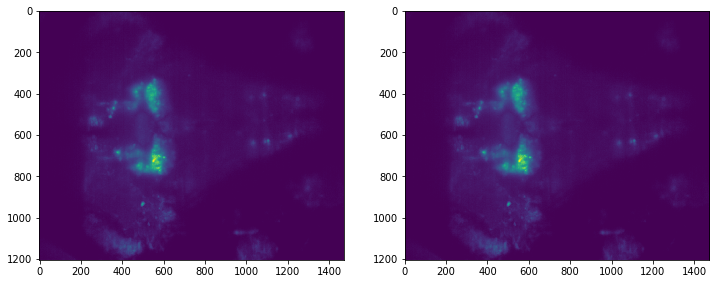

In [38]:
if shifts is None:
    reg_roi = (slice(None), slice(None), slice(None), slice(None))
    fig, axs = plt.subplots(ncols=2, figsize=(12,12))
    axs[0].imshow(anat_ref.max(0).squeeze(), clim=(100,200))
    axs[1].imshow(anat_ref[reg_roi[1:]].max(0).squeeze(), clim=(100,200))

In [39]:
%%time
if shifts is None:
    cluster.start_workers(300)
    ref_mx_bc = client.scatter(anat_ref[reg_roi[1:]].max(0), broadcast=True)
    data_filt = data[reg_roi].astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    if data_filt.shape[0] > 20000:
        ds_t = 4
        full_t = np.arange(data_filt.shape[0])
        affines_ds = da.map_blocks(reg, ref_mx_bc, data_filt[::ds_t].max(1), dtype='float32', chunks=(1,2,2)).compute()
        interper = interp1d(full_t[::ds_t], affines_ds, axis=0, bounds_error=False)
        affines = interper(full_t)        
    else:
        affines = da.map_blocks(reg, ref_mx_bc, data_filt.max(1), dtype='float32', chunks=(1,2,2)).compute()    
    np.save(reg_path, affines)
    shifts = -affines[:,:-1,-1]
    cluster.stop_all_jobs()

CPU times: user 1min 54s, sys: 22.2 s, total: 2min 16s
Wall time: 9min 48s


Text(0, 0.5, 'Translation (um)')

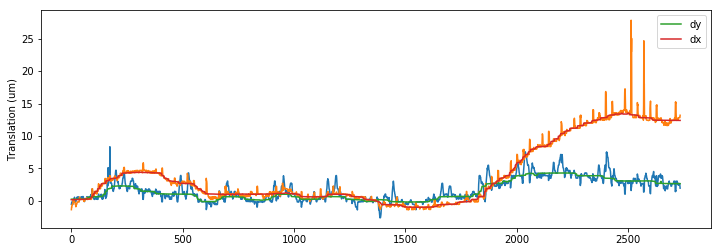

In [40]:
fig, axs = plt.subplots(figsize=(12,4))
um_per_pix = .40625
axs.plot(shifts * um_per_pix)
shifts_filt = median_filter(shifts, size=(150,1))
axs.plot(shifts_filt * um_per_pix)
axs.legend(axs.lines[2:], ['dy','dx'])
axs.set_ylabel('Translation (um)')

In [45]:
%%time
cluster.start_workers(10)
time.sleep(10)
shifts_filt_bc = client.scatter(shifts_filt)
medfilt = partial(median_filter, size=(1,1,3,3))
data_filt = data.astype('float32').map_blocks(medfilt, dtype='float32')
data_tx = data_filt.map_blocks(shift_yx, shifts_filt_bc, dtype='float32')

data_ds = coarsen(np.mean, data_tx, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 'auto', 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

CPU times: user 2.16 s, sys: 707 ms, total: 2.86 s
Wall time: 11.9 s


In [46]:
%%time
cluster.start_workers(100)
result = data_dff.compute().squeeze()
time.sleep(10)
cluster.stop_all_jobs()

CPU times: user 3min 51s, sys: 4min 11s, total: 8min 3s
Wall time: 10min 25s


In [47]:
%%time
imsave(dff_movie_fname, result, imagej=True)

CPU times: user 2min 36s, sys: 53 s, total: 3min 29s
Wall time: 3min 28s


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1088: UserWarning: truncating ImageJ file
  warnings.warn("truncating ImageJ file")


In [48]:
result.shape

(2736, 41, 301, 368)

In [49]:
import flika as flk
flk.start_flika()
if single_plane:
    win = flk.window.Window(result)
else:
    win = flk.window.Window(result.max(1))

Starting flika
flika menubar already initialized.
Starting flika inside IPython


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


Triggered average for optogenetics movies

really this should be in a separate file but I want to keep all the boilerplate at the top of this one

In [9]:
from skimage.io import imread
from fish.ephys.ephys import load, estimate_onset, chop_trials
from glob import glob
from h5py import File

#ep_fname = glob(base_dir  + '*.10chFlt')[0]
ep_fname= '/nrs/ahrens/davis/y333ReaChr_HucGC6s-after_add_food.10chFlt'
epdat = load(ep_fname)
trs = chop_trials(epdat[4])
trs.pop(-1);

In [10]:
result = imread(dff_movie_fname)

In [11]:
if single_plane:
    frame = estimate_onset(epdat[2], threshold=2, duration=100)[:result.shape[0]]
else:
    frame = estimate_onset(epdat[2], threshold=3.7, duration=100)[:result.shape[0]]

trigger_frames = []
window = np.arange(int(-5 * fs_im), int(20 * fs_im))
for conds in trs.keys():
    triggers_ep = trs[conds][0]
    triggers_ep = triggers_ep[triggers_ep < frame[-1]]
    tf = np.zeros(triggers_ep.shape, dtype='int')
    
    for ind, tr in enumerate(triggers_ep):
        candidate = np.where((frame-tr) > 0)[0][0]
        if (candidate + window).max() < result.shape[0]:
            tf[ind] = candidate
    trigger_frames.append(tf)

In [13]:
tr_ave_fname = f'{reg_dir}{exp_name}_dff_trave_ds{ds_xy}.h5'
with File(tr_ave_fname, 'w') as hf:
    for ind, times in enumerate(trigger_frames):
        trinds = (window + times.reshape(-1,1))
        tr_ave = result[trinds].astype('float32')
        tr_ave_tif_fname = f'{reg_dir}{exp_name}_dff_trave_ds{ds_xy}_cond{ind}.tif'
        imsave(tr_ave_tif_fname, tr_ave.mean(0), imagej=True)
        hf[f'condition_{ind}/trave'] = tr_ave        
        hf[f'condition_{ind}/trinds'] = trinds
        hf[f'condition_{ind}/window'] = window

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /groups/ahrens/ahrenslab/davis/tmp/y333ReaChR_HucGC6s-mainWithFood_20190117_180250/y333ReaChR_HucGC6s-mainWithFood_20190117_180250_dff_trave_ds4_cond2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [17]:
f=File(tr_ave_fname, 'r')

In [10]:
import flika as flk
flk.start_flika()
from flika.window import Window as flw

Starting flika
Starting flika inside IPython


In [20]:
flw(f['condition_0/trave'][:].mean(0).max(1))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]
